In [29]:
import numpy as np
import scipy as sc
import random as rand
from sklearn import preprocessing, linear_model
import matplotlib.pyplot as plt

from controller.pd_controller import PDController
from dynamics.linear_system_dynamics import LinearSystemDynamics
from dynamics.configuration_dynamics import ConfigurationDynamics

from controller.openloop_controller import OpenLoopController
from controller.mpc_controller import MPCController
from controller.bilinear_fb_lin_controller import BilinearFBLinController
from controller.perturbed_controller import PerturbedController
from controller.linear_lifted_controller import LinearLiftedController
from dynamics.linear_lifted_dynamics import LinearLiftedDynamics
from dynamics.bilinear_lifted_dynamics import BilinearLiftedDynamics
from learning.edmd import Edmd
from learning.bilinear_edmd import BilinearEdmd
from basis__functions.planar_quad_basis import PlanarQuadBasis

from learning.utils import differentiate_vec

from systems.planar_quadrotor_force_input import PlanarQuadrotorForceInput

class QuadrotorPdOutput(ConfigurationDynamics):
    def __init__(self, dynamics, xd, t_d, n, m):
        ConfigurationDynamics.__init__(self, dynamics, 1)
        self.xd = xd
        self.t_d = t_d
        self.xd_dot = differentiate_vec(self.xd, self.t_d)
        self.n = n
        self.m = m

    def proportional(self, x, t):
        q, q_dot = x[:int(n/2)], x[int(n/2):]
        return self.y(q) - self.y_d(t)

    def derivative(self, x, t):
        q, q_dot = x[:int(n/2)], x[int(n/2):]
        return self.dydq(q)@q_dot - self.y_d_dot(t)

    def y(self, q):
        return q

    def dydq(self, q):
        return np.eye(int(self.n/2))

    def d2ydq2(self, q):
        return np.zeros((int(self.n/2), int(self.n/2), int(self.n/2)))

    def y_d(self, t):
        return self.desired_state_(t)[:int(self.n/2)]

    def y_d_dot(self, t):
        return self.desired_state_(t)[int(self.n/2):]

    def y_d_ddot(self, t):
        return self.desired_state_dot_(t)[int(self.n/2):]

    def desired_state_(self, t):
        return [np.interp(t, self.t_d.flatten(),self.xd[:,ii].flatten()) for ii in range(self.xd.shape[1])]

    def desired_state_dot_(self, t):
        return [np.interp(t, self.t_d.flatten(),self.xd_dot[:,ii].flatten()) for ii in range(self.xd_dot.shape[1])]

class PlanarQuadrotorForceInputDiscrete(PlanarQuadrotorForceInput):
    def __init__(self, mass, inertia, prop_arm, g=9.81, dt=1e-2):
        PlanarQuadrotorForceInput.__init__(self, mass, inertia, prop_arm, g=g)
        self.dt=dt
        
    def eval_dot(self, x, u, t):
        return x + self.dt*self.drift(x, t) + self.dt*np.dot(self.act(x, t),u)

    def get_linearization(self, x0, x1, u0, t):
        m, J, b, g = self.params
        A_lin = np.eye(self.n) + self.dt*np.array([[0, 0, 0, 1, 0, 0],
                                                   [0, 0, 0, 0, 1, 0],
                                                   [0, 0, 0, 0, 0, 1],
                                                   [0, 0, -(1/m)*np.cos(x0[2])*u0[0] -(1/m)*np.cos(x0[2])*u0[1], 0, 0, 0],
                                                   [0, 0, -(1/m)*np.sin(x0[2])*u0[0] -(1/m)*np.sin(x0[2])*u0[1], 0, 0, 0],
                                                   [0, 0, 0, 0, 0, 0],])

        B_lin = self.dt*np.array([[0, 0],
                                  [0, 0],
                                  [0, 0],
                                  [-(1/m)*np.sin(x0[2]), -(1/m)*np.sin(x0[2])],
                                  [(1/m)*np.cos(x0[2]), (1/m)*np.cos(x0[2])],
                                  [-b/J, b/J]])

        if x1 is None:
            x1 = A_lin@x0 + B_lin@u0

        f_d = self.eval_dot(x0,u0,t)
        r_lin = f_d - x1

        return A_lin, B_lin, r_lin
    

## Planar Quadrotor Example

Consider a planar quadrotor with states $\mathbf{x} = [y \, z \, \theta \, \dot{y} \, \dot{z} \, \dot{\theta}]^T$ and continuous-time dynamics

\begin{equation}
    \begin{bmatrix} \ddot{y} \\ \ddot{z} \\ \ddot{\theta} \end{bmatrix}
    = \begin{bmatrix}
    0\\-g\\0
    \end{bmatrix} +
    \begin{bmatrix}
    -\frac{1}{m}\text{sin}\theta & -\frac{1}{m}\text{sin}\theta\\
    \frac{1}{m}\text{cos}\theta & \frac{1}{m}\text{cos}\theta\\
    -\frac{l_{arm}}{I_{xx}} & \frac{l_{arm}}{I_{xx}}
    \end{bmatrix}
    \begin{bmatrix}
    T_1 \\ T_2
    \end{bmatrix}
\end{equation}

where $y,z$ describe the position of the vehicle in a fixed reference frame, $\theta$ is the orientation of the vehicle,
$T_1, T_2$ are the thrust from each of the propellers, $g$ is the gravitational acceleration, $m$ is the vehicle mass,
$l_{arm}$ is the distance from the vehicle's center of mass to the center of the propeller, and $I_{xx}$ is the inertia
around the x-axis.

In [30]:
"""
This code defines the parameters and linearized system specification for our system.

Parameters:
- mass: Mass of the cart pole system.
- inertia: Inertia of the cart pole system.
- prop_arm: Propeller arm length of the quadrotor.
- gravity: Acceleration due to gravity.

Linearized System Specification:
- n: Number of states.
- m: Number of control inputs.
- A_nom: Linearization of the true system around the origin.
- B_nom: Linearization of the true system around the origin.
- hover_thrust: Hover thrust of the quadrotor.

"""

mass = 2.
inertia = 1.
prop_arm = 0.2
gravity = 9.81
quadrotor = PlanarQuadrotorForceInput(mass, inertia, prop_arm, g=gravity)

n, m = 6, 2
A_nom = np.array([[0., 0., 0., 1., 0., 0.],
                  [0., 0., 0., 0., 1., 0.],
                  [0., 0., 0., 0., 0., 1.],
                  [0., 0., -gravity, 0., 0., 0.],
                  [0., 0., 0., 0., 0., 0.],
                  [0., 0., 0., 0., 0., 0.]])
B_nom = np.array([[0., 0.],
                  [0., 0.],
                  [0., 0.],
                  [0., 0.],
                  [1./mass, 1./mass],
                  [-prop_arm/inertia, prop_arm/inertia]])

hover_thrust = mass*gravity/m


### Collect data for learning

To collect data, a nominal controller is designed with LQR on the dynamics's linearization around hover. However, any
controller can be used and the method does not require the knowledge of model's linearization. In addition, a
exploratory white noise is added to the controller to ensure that the data is sufficiently excited. Note that the system
is underactuated and that trajectory optimization is necessary to control the position of the vehicle. We use a
simplified trajectory generator based on a model predictive controller for the linearized dynamics. More careful design
of the desired trajectory may be necessary for more demanding applications and this is readily compatible with our method.



In [31]:

#drive.mount("/content/drive", force_remount=True)

q_dc, r_dc = 5e2, 1                                                 # State and actuation penalty values, data collection
Q_dc = q_dc * np.identity(n)                                        # State penalty matrix, data collection
R_dc = r_dc*np.identity(m)                                          # Actuation penalty matrix, data collection
P_dc = sc.linalg.solve_continuous_are(A_nom, B_nom, Q_dc, R_dc)     # Algebraic Ricatti equation solution, data collection
K_dc = np.linalg.inv(R_dc)@B_nom.T@P_dc                             # LQR feedback gain matrix, data collection
K_dc_p = K_dc[:,:int(n/2)]                                          # Proportional control gains, data collection
K_dc_d = K_dc[:,int(n/2):]                                          # Derivative control gains, data collection
nominal_sys = LinearLiftedDynamics(A_nom, B_nom, np.eye(n), lambda x: x)

# Data collection parameters:
dt = 1.0e-2                                                         # Time step length
traj_length_dc = 2.                                                 # Trajectory length, data collection
n_pred_dc = int(traj_length_dc/dt)                                  # Number of time steps, data collection
t_eval = dt * np.arange(n_pred_dc + 1)                              # Simulation time points
n_traj_train = 200                                                  # Number of trajectories to execute, data collection
n_traj_val = int(0.25*n_traj_train)

noise_var = 5.                                                      # Exploration noise to perturb controller, data collection

xmax = np.array([2, 2, np.pi/3, 2.,2.,2.])                          # State constraints, trajectory generation
xmin = -xmax
umax = np.array([2*hover_thrust, 2*hover_thrust])                    # Actuation constraint, trajectory generation
umin = np.array([0., 0.])
x0_max = np.array([xmax[0], xmax[1], xmax[2], 1., 1., 1.])          # Initial value limits
Q_trajgen = sc.sparse.diags([0,0,0,0,0,0])                          # State penalty matrix, trajectory generation
QN_trajgen = sc.sparse.diags([5e1,5e1,5e1,1e1,1e1,1e1])             # Final state penalty matrix, trajectory generation
R_trajgen = sc.sparse.eye(m)                                        # Actuation penalty matrix, trajectory generation
sub_sample_rate = 1                                                 # Rate to subsample data for training
model_fname = '/Research_data'                         # Path to save learned models
n_cols = 10                                                         # Number of columns in training data plot
save_figures = True
#dropbox_folder = '/Users/carlaxelfolkestad/Dropbox/Apps/Overleaf/Koopman NMPC (ICRA21)/'

In [32]:
# Load data
data = np.load('Research_data/training_data.npz')
xd = data['xd']
xs = data['xs']
us = data['us']

# Optionally, load the number of training and validation trajectories
trajectory_counts = np.load('Research_data/trajectory_counts.npz')
n_traj_train = trajectory_counts['n_traj_train']
n_traj_val = trajectory_counts['n_traj_val']

In [33]:
# Split the data into training and validation sets
xs_train = xs[:n_traj_train, :, :]
us_train = us[:n_traj_train, :, :]

xs_val = xs[n_traj_train:, :, :]
us_val = us[n_traj_train:, :, :]

In [34]:
# xd = np.empty((n_traj_train + n_traj_val, n_pred_dc + 1, n))
# xs = np.empty((n_traj_train + n_traj_val, n_pred_dc + 1, n))
# us = np.empty((n_traj_train + n_traj_val, n_pred_dc, m))

# plt.figure(figsize=(12, 12 * (n_traj_train + n_traj_val) / (n_cols ** 2)))
# for ii in range(n_traj_train+n_traj_val):
#     x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
#     set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
#     mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
#                                 QN_trajgen, set_pt_dc)
#     mpc_trajgen.eval(x0, 0)
#     xd[ii, :, :] = mpc_trajgen.parse_result().T
#     while abs(x0[0]) + abs(x0[1]) < 1 or np.any(np.isnan(xd[ii, :, :])):
#         x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
#         set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
#         mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin-hover_thrust, umax-hover_thrust, xmin, xmax, QN_trajgen, R_trajgen,
#                                     QN_trajgen, set_pt_dc)
#         mpc_trajgen.eval(x0, 0)
#         xd[ii, :, :] = mpc_trajgen.parse_result().T

#     output = QuadrotorPdOutput(quadrotor, xd[ii, :, :], t_eval, n, m)
#     pd_controller = PDController(output, K_dc_p, K_dc_d)
#     perturbed_pd_controller = PerturbedController(quadrotor, pd_controller, noise_var, const_offset=hover_thrust)
#     xs[ii, :, :], us[ii, :, :] = quadrotor.simulate(x0, perturbed_pd_controller, t_eval)

#     plt.subplot(int(np.ceil((n_traj_train + n_traj_val) / n_cols)), n_cols, ii + 1)
#     plt.plot(t_eval, xs[ii, :, 0], 'b', label='$y$')
#     plt.plot(t_eval, xs[ii, :, 1], 'g', label='$z$')
#     plt.plot(t_eval, xs[ii, :, 2], 'r', label='$\\theta$')
#     plt.plot(t_eval, xd[ii, :, 0], '--b', label='$y_d$')
#     plt.plot(t_eval, xd[ii, :, 1], '--g', label='$z_d$')
#     plt.plot(t_eval, xd[ii, :, 2], '--r', label='$\\theta_d$')

# plt.suptitle(
#     'Training data \nx-axis: time (sec), y-axis: state value, $x$ - blue, $xd$ - dotted blue, $\\theta$ - red, $\\theta_d$ - dotted red',
#     y=0.94)
# plt.show()

# xs_train, us_train = xs[:n_traj_train,:,:], us[:n_traj_train, :, :]
# xs_val, us_val = xs[n_traj_train:,:,:], us[n_traj_train:, :, :]

In [35]:
#import numpy as np

# Assuming xd, xs, and us are already generated

# Save xd, xs, and us
#np.savez('/content/drive/My Drive/Research/training_data.npz', xd=xd, xs=xs, us=us)

# Optionally, save the number of training and validation trajectories
#np.savez('/content/drive/My Drive/Research/trajectory_counts.npz', n_traj_train=n_traj_train, n_traj_val=n_traj_val)


### Learn a linear model with dynamic mode decomposition (DMD)

To compare our method with existing techniques, we first learn a linear state space model from data. This is dubbed
dynamic mode decomposition. I.e. we use linear regression with LASSO regularization to learn an approximate linear model
with model structure

\begin{equation}
    \mathbf{\dot{x}} = A_{dmd}\mathbf{x} + B_{dmd}\mathbf{u}
\end{equation}

In [36]:
#DMD parameters:
alpha_dmd = 9.8e-5                                                  # Regularization strength (LASSO) DMD
tune_mdl_dmd = False

In [37]:
basis = lambda x: x
C_dmd = np.eye(n)

optimizer_dmd = linear_model.MultiTaskLasso(alpha=alpha_dmd, fit_intercept=False, selection='random')
cv_dmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random')
standardizer_dmd = preprocessing.StandardScaler(with_mean=False)

model_dmd = Edmd(n, m, basis, n, n_traj_train, optimizer_dmd, cv=cv_dmd, standardizer=standardizer_dmd, C=C_dmd, first_obs_const=False, continuous_mdl=False, dt=dt)
xdmd, y_dmd = model_dmd.process(xs_train, us_train, np.tile(t_eval,(n_traj_train,1)), downsample_rate=sub_sample_rate)
model_dmd.fit(xdmd, y_dmd, cv=tune_mdl_dmd, override_kinematics=True)
sys_dmd = LinearLiftedDynamics(model_dmd.A, model_dmd.B, model_dmd.C, model_dmd.basis, continuous_mdl=False, dt=dt)
if tune_mdl_dmd:
    print('$\\alpha$ DMD: ',model_dmd.cv.alpha_)

### Learn a lifted linear model with extended dynamic mode decomposition (EDMD)

In addition, we compare our method with the current state of the art of Koopman based learning, the extended dynamic mode
decomposition. We use a dictionary of nonlinear functions $\boldsymbol{\phi(x)}$ to lift the state variables and learn a lifted state space model
of the dynamics. I.e. we first lift and then use linear regression with LASSO regularization to learn an approximate
lifted linear model with model structure

\begin{equation}
    \mathbf{\dot{z}} = A_{edmd}\mathbf{z} + B_{edmd}\mathbf{u}, \qquad \mathbf{z} = \boldsymbol{\phi(x)}
\end{equation}

In [38]:
#EDMD parameters:
alpha_edmd = 2.22e-4                                                 # Regularization strength (LASSO) EDMD
tune_mdl_edmd = False

In [39]:
basis = PlanarQuadBasis(n, poly_deg=3)
basis.construct_basis()
planar_quad_features = preprocessing.FunctionTransformer(basis.basis)
planar_quad_features.fit(np.zeros((1,n)))
n_lift_edmd = planar_quad_features.transform((np.zeros((1,n)))).shape[1]
C_edmd = np.zeros((n,n_lift_edmd))
C_edmd[:,1:n+1] = np.eye(n)

optimizer_edmd = linear_model.MultiTaskLasso(alpha=alpha_edmd, fit_intercept=False, selection='random', max_iter=2000)
cv_edmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random', max_iter=2000)
standardizer_edmd = preprocessing.StandardScaler(with_mean=False)

model_edmd = Edmd(n, m, basis.basis, n_lift_edmd, n_traj_train, optimizer_edmd, cv=cv_edmd, standardizer=standardizer_edmd, C=C_edmd, continuous_mdl=False, dt=dt)
X_edmd, y_edmd = model_edmd.process(xs_train, us_train, np.tile(t_eval,(n_traj_train,1)), downsample_rate=sub_sample_rate)
model_edmd.fit(X_edmd, y_edmd, cv=tune_mdl_edmd, override_kinematics=True)
sys_edmd = LinearLiftedDynamics(model_edmd.A, model_edmd.B, model_edmd.C, model_edmd.basis, continuous_mdl=False, dt=dt)
if tune_mdl_edmd:
    print('$\\alpha$ EDMD: ',model_edmd.cv.alpha_)


### Learn a lifted bilinear model with bilinear extended mode decomposition (bEDMD)

Finally, we use the method developed in the paper to learn a lifted bilinear model of the dynamics, dubbed bilinear
extended mode decomposition (bEDMD). I.e. we first lift and then use linear regression with LASSO regularization to learn an approximate
lifted linear model with model structure

\begin{equation}
    \mathbf{\dot{z}}=F\mathbf{z}+\sum_{i=1}^m G_i\mathbf{z}\mathbf{u}_i, \qquad \mathbf{z} = \boldsymbol{\phi(x)}
\end{equation}

In [40]:
#Bilinear EDMD parameters:                                           
alpha_bedmd = 6.9e-5  # Regularization strength (LASSO) bEDMD
tune_mdl_bedmd = False

In [41]:
# n_lift_bedmd = n_lift_edmd
# C_bedmd = np.zeros((n,n_lift_bedmd))
# C_bedmd[:,1:n+1] = np.eye(n)

# basis_bedmd = lambda x: planar_quad_features.transform(x)
# optimizer_bedmd = linear_model.MultiTaskLasso(alpha=alpha_bedmd, fit_intercept=False, selection='random', max_iter=1e4)
# cv_bedmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random')
# standardizer_bedmd = preprocessing.StandardScaler(with_mean=False)

# model_bedmd = BilinearEdmd(n, m, basis_bedmd, n_lift_bedmd, n_traj_train, optimizer_bedmd, cv=cv_bedmd, standardizer=standardizer_bedmd, C=C_bedmd, continuous_mdl=False, dt=dt)
# X_bedmd, y_bedmd = model_bedmd.process(xs_train, us_train, np.tile(t_eval,(n_traj_train,1)), downsample_rate=sub_sample_rate)
# model_bedmd.fit(X_bedmd, y_bedmd, cv=tune_mdl_bedmd, override_kinematics=True)
# sys_bedmd = BilinearLiftedDynamics(model_bedmd.n_lift, m, model_bedmd.A, model_bedmd.B, model_bedmd.C, model_bedmd.basis, continuous_mdl=False, dt=dt)
# if tune_mdl_bedmd:
#     print('$\\alpha$ bilinear EDMD: ', model_bedmd.cv.alpha_)
    


In [42]:
import dill

# # Prepare the data to be saved in a dictionary (optional but organized)
# save_data = {
#     'n_lift_bedmd': n_lift_bedmd,
#     'C_bedmd': C_bedmd,
#     'basis_bedmd': basis_bedmd,
#     'optimizer_bedmd': optimizer_bedmd,
#     'cv_bedmd': cv_bedmd,
#     'standardizer_bedmd': standardizer_bedmd,
#     'model_bedmd': model_bedmd,
#     'X_bedmd': X_bedmd,
#     'y_bedmd': y_bedmd,
#     'sys_bedmd': sys_bedmd,
#     'alpha_bedmd': model_bedmd.cv.alpha_ if tune_mdl_bedmd else None,
# }

# # Specify your save file path
# file_path = '/content/drive/My Drive/Research/bedmd_model_results.dill'

# # Use dill to save the data
# with open(file_path, 'wb') as outfile:
#     dill.dump(save_data, outfile)


In [43]:
file_path = 'Research_data/bedmd_model_results.dill'
with open(file_path, 'rb') as infile:
    loaded_data = dill.load(infile)

# Accessing your data
basis_bedmd = loaded_data['basis_bedmd']  # This might require special handling if it's a lambda function
optimizer_bedmd = loaded_data['optimizer_bedmd']
cv_bedmd = loaded_data['cv_bedmd']
standardizer_bedmd = loaded_data['standardizer_bedmd']
model_bedmd = loaded_data['model_bedmd']
X_bedmd = loaded_data['X_bedmd']
y_bedmd = loaded_data['y_bedmd']
sys_bedmd = loaded_data['sys_bedmd']
alpha_bedmd = loaded_data['alpha_bedmd']  # This captures the alpha value if tuning was performed


/Users/yoni/Documents/Research/core/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MultiTaskLasso from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/yoni/Documents/Research/core/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MultiTaskLassoCV from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/yoni/Documents/Research/core/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle

## Learn Koopman bilinear form neural network model (Koop_dnn)

In [44]:
# Ensure dill and torch are available in your environment


# Initialize network parameters for a new training session
net_params = {
    'state_dim': n,  # State dimension
    'ctrl_dim': m,  # Control dimension
    'encoder_hidden_width': 100,  # Width of hidden layers in the encoder
    'encoder_hidden_depth': 4,  # Number of hidden layers in the encoder
    'encoder_output_dim': 8,  # Output dimension of the encoder
    'optimizer': 'adam',  # Optimizer to use
    'activation_type': 'tanh',  # Activation function
    'lr': 1e-3,  # Learning rate, consider experimenting with 5e-4 as well
    'epochs': 2000,  # Number of training epochs for best performance
    'batch_size': 128,  # Batch size
    'lin_loss_penalty': 0.2,  # Linear loss penalty, best performance so far
    'l2_reg': 0.0,  # L2 regularization, best performance so far
    'l1_reg': 0.0,  # L1 regularization
    'n_fixed_states': 6,  # Number of fixed states
    'first_obs_const': True,  # Whether the first observation is constant
    'override_kinematics': True,  # Whether to override kinematics
    'override_C': True,  # Whether to override the C matrix
    'dt': dt,  # Time step for the model
}

# Print the network parameters to verify configuration
print(net_params)


{'state_dim': 6, 'ctrl_dim': 2, 'encoder_hidden_width': 100, 'encoder_hidden_depth': 4, 'encoder_output_dim': 8, 'optimizer': 'adam', 'activation_type': 'tanh', 'lr': 0.001, 'epochs': 2000, 'batch_size': 128, 'lin_loss_penalty': 0.2, 'l2_reg': 0.0, 'l1_reg': 0.0, 'n_fixed_states': 6, 'first_obs_const': True, 'override_kinematics': True, 'override_C': True, 'dt': 0.01}


In [45]:
# %pip install dill
# import dill, os, torch

# load_tuned_params = False

# if load_tuned_params:
#     infile = open(os.path.abspath('') + '/data/planar_quad_best_params.pickle', 'rb')
#     net_params_lst, val_loss, test_loss, open_loop_mse, open_loop_std = dill.load(infile)
#     infile.close()
#     net_params = net_params_lst[-3]

#     print(open_loop_mse)
#     plt.figure()
#     plt.plot(val_loss, label='Validation loss')
#     plt.plot(test_loss, label='Test loss')
#     plt.plot(open_loop_mse, label='Open loop mse')
#     plt.legend()
#     plt.show()

# else:
#     net_params = {}
#     net_params['state_dim'] = n
#     net_params['ctrl_dim'] = m
#     net_params['encoder_hidden_width'] = 100
#     net_params['encoder_hidden_depth'] = 4
#     net_params['encoder_output_dim'] = 8
#     net_params['optimizer'] = 'adam'
#     net_params['activation_type'] = 'tanh'
#     net_params['lr'] = 1e-3 # 5e-4
#     net_params['epochs'] = 2000 # Best performance 2000
#     net_params['batch_size'] = 128
#     net_params['lin_loss_penalty'] = 0.2 #Best performance until now: 0.2
#     net_params['l2_reg'] = 0.0          #Best performance until now: 0.0
#     net_params['l1_reg'] = 0.0
#     net_params['n_fixed_states'] = 6
#     net_params['first_obs_const'] = True
#     net_params['override_kinematics'] = True
#     net_params['override_C'] = True
#     net_params['dt'] = dt

# print(net_params)

In [46]:
# def fit_standardizer(data, standardizer, flattened=False):
#     if flattened:
#         data_flat = data
#     else:
#         n_traj, traj_length, n = data.shape
#         data_flat = data.T.reshape((n, n_traj * traj_length), order='F').T

#     standardizer.fit(data_flat)

#     return standardizer

# #standardizer_x_kdnn = fit_standardizer(xs_train, preprocessing.StandardScaler())
# standardizer_u_kdnn = fit_standardizer(us_train, preprocessing.StandardScaler(with_mean=False))

# #net = KoopmanNetCtrl(net_params, standardizer_x=standardizer_x_kdnn, standardizer_u=standardizer_u_kdnn)
# net = KoopmanNetCtrl(net_params, standardizer_u=standardizer_u_kdnn)
# model_koop_dnn = KoopDnn(net)
# model_koop_dnn.set_datasets(xs_train, np.tile(t_eval,(n_traj_train,1)), u_train=us_train, x_val=xs_val, u_val=us_val, t_val=np.tile(t_eval,(n_traj_val,1)))
# model_koop_dnn.model_pipeline(net_params)
# model_koop_dnn.construct_koopman_model()
# sys_koop_dnn = BilinearLiftedDynamics(model_koop_dnn.net.n_tot, m, model_koop_dnn.A, model_koop_dnn.B, np.array(model_koop_dnn.C, dtype=float), model_koop_dnn.basis_encode,
#                                     continuous_mdl=False, dt=dt, standardizer_u=standardizer_u_kdnn)

In [47]:
# import dill

# save_path = '/content/drive/My Drive/Research/koop_dnn_model.dill'  # Adjust path as needed

# # Bundle everything you want to save into a dictionary
# save_data = {
#     'net_params': net_params,
#     'standardizer_u_kdnn': standardizer_u_kdnn,
#     'model_koop_dnn': model_koop_dnn,
#     'sys_koop_dnn': sys_koop_dnn,
# }

# # Use dill to save the data
# with open(save_path, 'wb') as outfile:
#     dill.dump(save_data, outfile)

# print(f'Model and components saved to {save_path}')


In [48]:
import dill

load_path = 'Research_data/koop_dnn_model.dill'  # Adjust path as needed

# Use dill to load the data
with open(load_path, 'rb') as infile:
    loaded_data = dill.load(infile)

# Extract your components
net_params = loaded_data['net_params']
standardizer_u_kdnn = loaded_data['standardizer_u_kdnn']
model_koop_dnn = loaded_data['model_koop_dnn']
sys_koop_dnn = loaded_data['sys_koop_dnn']

print('Model and components loaded successfully.')

Model and components loaded successfully.


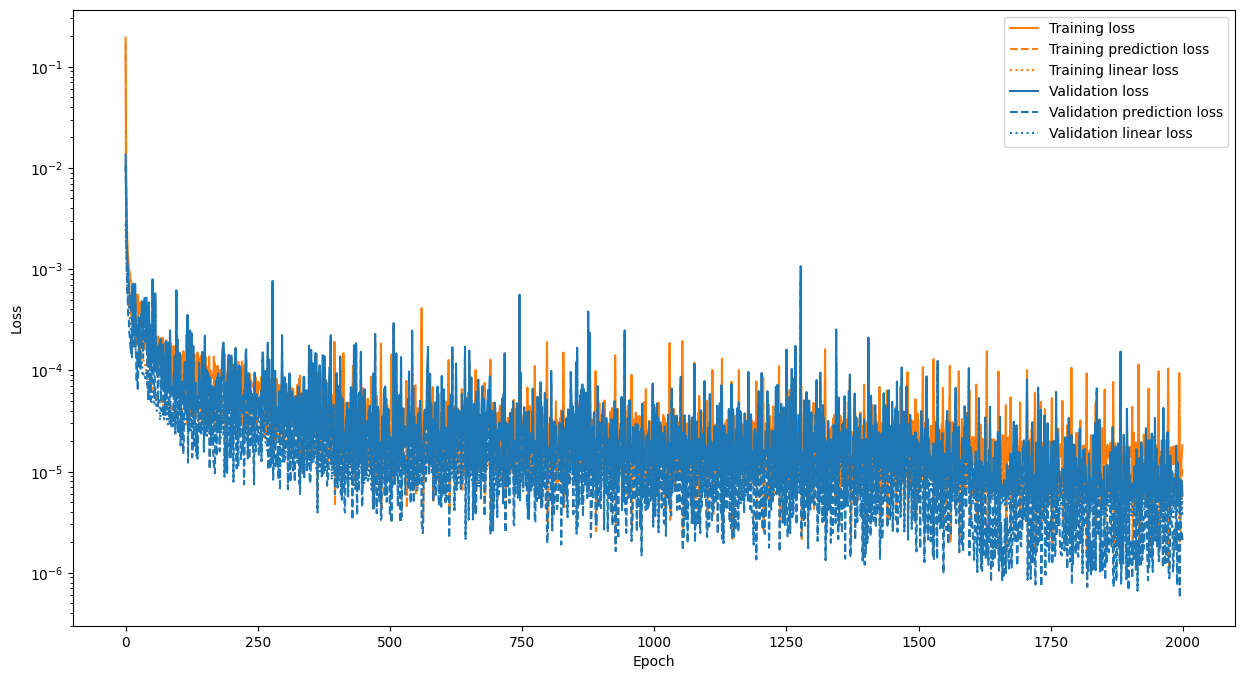

In [49]:
import numpy as np
import matplotlib.pyplot as plt
train_loss = [l[0] for l in model_koop_dnn.train_loss_hist]
train_pred_loss = [l[1] for l in model_koop_dnn.train_loss_hist]
train_lin_loss = [l[2] for l in model_koop_dnn.train_loss_hist]
val_loss = [l[0] for l in model_koop_dnn.val_loss_hist]
val_pred_loss = [l[1] for l in model_koop_dnn.val_loss_hist]
val_lin_loss = [l[2] for l in model_koop_dnn.val_loss_hist]
epochs = np.arange(0, net_params['epochs'])

plt.figure(figsize=(15,8))
plt.plot(epochs, train_loss, color='tab:orange', label='Training loss')
plt.plot(epochs, train_pred_loss, '--', color='tab:orange', label='Training prediction loss')
plt.plot(epochs, train_lin_loss, ':', color='tab:orange', label='Training linear loss')
plt.plot(epochs, val_loss, color='tab:blue', label='Validation loss')
plt.plot(epochs, val_pred_loss, '--', color='tab:blue', label='Validation prediction loss')
plt.plot(epochs, val_lin_loss, ':', color='tab:blue', label='Validation linear loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

### Evaluate open loop prediction performance

We first evaluate the open loop prediction performance of the proposed method.
This is done by generating a new data set in the same way as the training set, predicting the evolution of the system
with the control sequence of each trajectory executed in the data set with each of the models, and finally comparing
the mean and standard deviation of the error between the true and predicted evolution over the trajectories. The
experimental results support what is to be expected from the theory as the error in the $y$ and $z$ terms are
significantly lower for the bEDMD method than both DMD and EDMD. The reason for this
improvement is that the bEDMD method can capture the nonlinearities present in the actuation matrix of the
$(y,z)$-dynamics.

In [50]:
# Prediction performance evaluation parameters:
folder_plots = 'working_files/figures/'                                  # Path to save plots
n_traj_ol = 100                                                     # Number of trajectories to execute, open loop

In [51]:
# Define file path for loading from Google Drive with the given filename
load_path = 'Research_data/open_loop_prediction_performance.dill'

# Deserialize and load data
with open(load_path, 'rb') as infile:
    loaded_data = dill.load(infile)

# Extract loaded data
xs_test = loaded_data['xs_test']
us_test = loaded_data['us_test']
mdl_lst = loaded_data['mdl_lst']  # Ensure custom classes/functions are defined
mdl_names = loaded_data['mdl_names']
error = loaded_data['error']
mse = loaded_data['mse']
std = loaded_data['std']

print('Data loaded successfully.')


/Users/yoni/Documents/Research/core/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PolynomialFeatures from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Data loaded successfully.


In [52]:
# from koopman_core.util import evaluate_ol_pred
from tabulate import tabulate

# xs_test = np.empty((n_traj_ol, t_eval.shape[0], n))
# us_test = np.empty((n_traj_ol, t_eval.shape[0]-1, m))

# for ii in range(n_traj_ol):
#     x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
#     set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
#     mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
#                                 QN_trajgen, set_pt_dc)
#     mpc_trajgen.eval(x0, 0)
#     xd = mpc_trajgen.parse_result().T

#     while xd[0,0] is None:
#         x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
#         set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
#         mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin-hover_thrust, umax-hover_thrust, xmin, xmax, QN_trajgen, R_trajgen,
#                                     QN_trajgen, set_pt_dc)
#         mpc_trajgen.eval(x0, 0)
#         xd = mpc_trajgen.parse_result().T

#     output = QuadrotorPdOutput(quadrotor, xd, t_eval, n, m)
#     pd_controller = PDController(output, K_dc_p, K_dc_d)
#     perturbed_pd_controller = PerturbedController(quadrotor, pd_controller, noise_var, const_offset=hover_thrust)

#     xs_test[ii,:,:], us_test[ii,:,:] = quadrotor.simulate(x0, perturbed_pd_controller, t_eval)

# mdl_lst = [sys_dmd, sys_edmd, sys_bedmd, sys_koop_dnn]
# mdl_names = ['DMD', 'EDMD', 'bEDMD', 'Koop DNN']
# error, mse, std = [], [], []

# for sys in mdl_lst:
#     err_tmp, mse_tmp, std_tmp = evaluate_ol_pred(sys, xs_test, np.tile(t_eval,(n_traj_ol,1)), us=us_test)
#     error.append(err_tmp)
#     mse.append(mse_tmp)
#     std.append(std_tmp)

# print('\nOpen loop performance statistics:')
# table_data = []
# for name, mse_mdl, std_mdl in zip(mdl_names, mse, std):
#     table_data.append([name, "{:.5f}".format(mse_mdl), "{:.5f}".format(std_mdl)])

# print(tabulate(table_data, 
#                headers=['Mean squared error', 'Standard deviation']))
print('\nOpen loop performance statistics:')
table_data = []
for name, mse_mdl, std_mdl in zip(mdl_names, mse, std):
    table_data.append([name, "{:.5f}".format(mse_mdl), "{:.5f}".format(std_mdl)])

print(tabulate(table_data,
               headers=['Mean squared error', 'Standard deviation']))



Open loop performance statistics:
            Mean squared error    Standard deviation
--------  --------------------  --------------------
DMD                    0.31114               0.53903
EDMD                   0.04903               0.21932
bEDMD                  0.00904               0.0951
Koop DNN               0.00624               0.07853


In [53]:
# import dill

# # Bundle data into a dictionary
# save_data = {
#     'xs_test': xs_test,
#     'us_test': us_test,
#     'mdl_lst': mdl_lst,  # This may require the models to be serializable
#     'mdl_names': mdl_names,
#     'error': error,
#     'mse': mse,
#     'std': std
# }

# # Define file path for saving in Google Drive with the given filename
# save_path = '/content/drive/My Drive/Research/open_loop_prediction_performance.dill'

# # Serialize and save data
# with open(save_path, 'wb') as outfile:
#     dill.dump(save_data, outfile)

# print(f'Data saved to {save_path}')

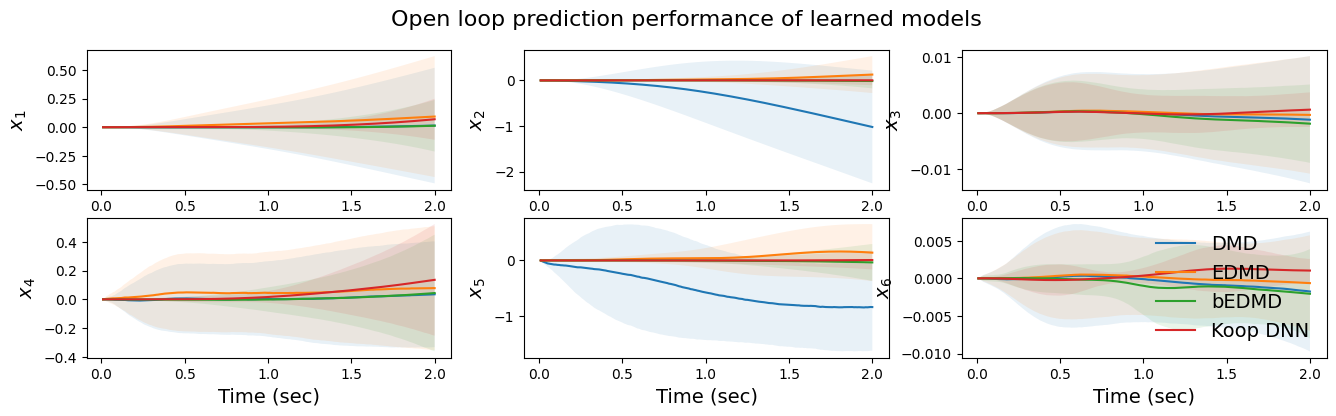

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import math

figwidth = 16
lw = 2
fs = 14
y_lim_gain = 1.2
row = 2


# Correct calculation for the number of columns
col = math.ceil(n / row)

# Plotting open loop results
plt.figure(figsize=(figwidth, 4))
axs = [plt.subplot(row, col, jj + 1) for jj in range(n)]

for ii, err in enumerate(error):
    err_mean = np.mean(err, axis=0)
    err_std = np.std(err, axis=0)

    for jj in range(n):
        axs[jj].plot(t_eval[1:], err_mean[:, jj], label=mdl_names[ii])
        axs[jj].fill_between(t_eval[1:], err_mean[:, jj] - err_std[:, jj], err_mean[:, jj] + err_std[:, jj], alpha=0.1)

for jj in range(n):
    axs[jj].set_xlabel('Time (sec)', fontsize=fs)
    axs[jj].set_ylabel('$x_' + str(jj + 1) + '$', fontsize=fs)

plt.legend(frameon=False, fontsize=fs)
stitle = plt.suptitle('Open loop prediction performance of learned models', fontsize=fs + 2)
plt.show()


# Design trajectories based on learned models

We now study the closed loop performance of the control design. 

In [55]:
solver_settings = {}
solver_settings['gen_embedded_ctrl'] = False
solver_settings['warm_start'] = True
solver_settings['polish'] = True
solver_settings['polish_refine_iter'] = 3
solver_settings['scaling'] = True
solver_settings['adaptive_rho'] = False
solver_settings['check_termination'] = 25
solver_settings['max_iter'] = 4000
solver_settings['eps_abs'] = 1e-6
solver_settings['eps_rel'] = 1e-6
solver_settings['eps_prim_inf'] = 1e-4
solver_settings['eps_dual_inf'] = 1e-4
solver_settings['linsys_solver'] = 'qdldl'

In [56]:
#Closed loop performance evaluation parameters:
traj_length=250
t_eval = dt * np.arange(traj_length+1)                       # Simulation time points, closed loop
Q_mpc = sc.sparse.diags([0,0,0,0,0,0])                       # State penalty matrix, trajectory generation
QN_mpc = sc.sparse.diags([1e5,1e5,1e5,1e5,1e5,1e5])         # Final state penalty matrix, trajectory generation
R_mpc = sc.sparse.eye(m)                                     # Actuation penalty matrix, trajectory generation
R0_mpc = sc.sparse.csc_matrix(np.zeros(m))

ctrl_offset = np.array([[hover_thrust], [hover_thrust]])

# Design trajectory:
x0_cl = np.array([-0.8, 0.1, 0.1, -0.3, -0.2, 0.15])                   # Initial value, closed loop trajectory
set_pt_cl = np.array([1.9, 1.2, 0., 0., 0., 0.])              # Desired final value, closed loop trajectory
xr_cl = np.tile(set_pt_cl.reshape(-1,1), (1, traj_length))
xmax = np.array([2, 2, np.pi/3, 2.,2.,2.])                          # State constraints, trajectory generation
xmin = -xmax
term_constraint=False

# Define initial solution for SQP algorithm:
x_init = np.linspace(x0_cl, set_pt_cl, int(traj_length)+1)
u_init = hover_thrust*np.ones((m,traj_length)).T

#### Design controllers for learned DMD, EDMD, and bEDMD models

In [57]:
# from koopman_core.controllers import MPCController, NonlinearMPCControllerNb, BilinearMPCControllerNb
from controller.mpc_controller import MPCController
from controller.bilinear_mpc_controller_numba import BilinearMPCControllerNb
from controller.nonlinear_mpc_controller_numba import NonlinearMPCControllerNb

# Define DMD-based controller:
controller_dmd = MPCController(sys_dmd, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint)

# Define EDMD-based controller:
controller_edmd = MPCController(sys_edmd, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint)

# Define bEDMD-based controller:
controller_bedmd = BilinearMPCControllerNb(sys_bedmd, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, solver_settings, terminal_constraint=term_constraint)
z0_bedmd_cl = sys_bedmd.lift(x0_cl.reshape((1,-1)), None).squeeze()
z_init = sys_bedmd.lift(x_init, None)
controller_bedmd.construct_controller(z_init, u_init)

# Define Koop NN controller:
controller_koop_dnn = BilinearMPCControllerNb(sys_koop_dnn, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, solver_settings, terminal_constraint=term_constraint)
z0_koop_dnn_cl = sys_koop_dnn.lift(x0_cl.reshape((1,-1)), None).squeeze()
z_init_koop_dnn = np.array(sys_koop_dnn.lift(x_init, None))
controller_koop_dnn.construct_controller(z_init_koop_dnn, u_init)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 6 is different from 27)

#### Design controller using full knowledge of nonlinear controller

In [ ]:
quadrotor_d = PlanarQuadrotorForceInputDiscrete(mass, inertia, prop_arm, g=gravity, dt=dt)
controller_nmpc = NonlinearMPCControllerNb(quadrotor_d, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, solver_settings, terminal_constraint=term_constraint)
controller_nmpc.construct_controller(x_init, u_init)

#### Design trajectories with the contructed MPCs

In [ ]:
max_iter = 100

controller_dmd.eval(x0_cl, 0)
xr_dmd = controller_dmd.parse_result()
ur_dmd = controller_dmd.get_control_prediction()

controller_edmd.eval(x0_cl, 0)
xr_edmd = sys_edmd.C@controller_edmd.parse_result()
ur_edmd = controller_edmd.get_control_prediction()

controller_bedmd.solve_to_convergence(z0_bedmd_cl, 0., z_init, u_init, max_iter=max_iter)
xr_bedmd = controller_bedmd.get_state_prediction().T
ur_bedmd = controller_bedmd.get_control_prediction().T

controller_koop_dnn.solve_to_convergence(z0_koop_dnn_cl, 0., z_init_koop_dnn, u_init, max_iter=max_iter)
xr_koop_dnn = controller_koop_dnn.get_state_prediction().T
ur_koop_dnn = controller_koop_dnn.get_control_prediction().T

/Users/carlaxelfolkestad/Coding_projects/koopman_learning_and_control/koopman_core/controllers/bilinear_mpc_controller_numba.py:14: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 2d, A))
  r_vec[i, :] = np.dot(z_init[i, :], A_reshaped[i*nx:(i+1)*nx, :])
/Users/carlaxelfolkestad/Coding_projects/koopman_learning_and_control/koopman_core/controllers/bilinear_mpc_controller_numba.py:9: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, F))
  B_lst_flat = (np.dot(z_init[:-1, :], B_arr)).flatten()


In [ ]:
controller_nmpc.solve_to_convergence(x0_cl, 0., x_init, u_init, max_iter=max_iter)
xr_nmpc = controller_nmpc.get_state_prediction().T
ur_nmpc = controller_nmpc.get_control_prediction().T

#### Simulate designed trajectories open loop

In [ ]:
ol_controller_dmd = OpenLoopController(quadrotor, ur_dmd.T, t_eval[:-1])
xs_dmd, us_dmd = quadrotor.simulate(x0_cl, ol_controller_dmd, t_eval)
xs_dmd, us_dmd = xs_dmd.T, us_dmd.T

ol_controller_edmd = OpenLoopController(quadrotor, ur_edmd.T, t_eval[:-1])
xs_edmd, us_edmd = quadrotor.simulate(x0_cl, ol_controller_edmd, t_eval)
xs_edmd, us_edmd = xs_edmd.T, us_edmd.T

ol_controller_bedmd = OpenLoopController(quadrotor, ur_bedmd.T, t_eval[:-1])
xs_bedmd, us_bedmd = quadrotor.simulate(x0_cl, ol_controller_bedmd, t_eval)
xs_bedmd, us_bedmd = xs_bedmd.T, us_bedmd.T

ol_controller_koop_dnn = OpenLoopController(quadrotor, ur_koop_dnn.T, t_eval[:-1])
xs_koop_dnn, us_koop_dnn = quadrotor.simulate(x0_cl, ol_controller_koop_dnn, t_eval)
xs_koop_dnn, us_koop_dnn = xs_koop_dnn.T, us_koop_dnn.T

ol_controller_nmpc = OpenLoopController(quadrotor, ur_nmpc.T, t_eval[:-1])
xs_nmpc, us_nmpc = quadrotor.simulate(x0_cl, ol_controller_nmpc, t_eval)
xs_nmpc, us_nmpc = xs_nmpc.T, us_nmpc.T

##### Compare performance

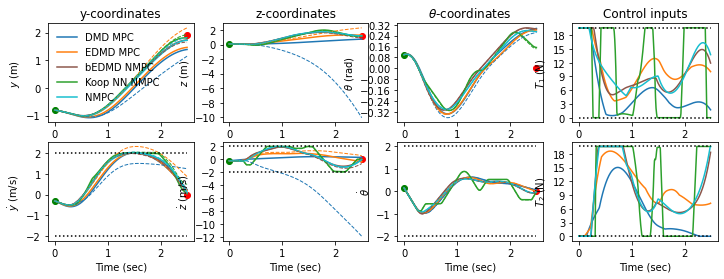

Solution statistics:

                       Normalized cost,    Realized terminal,  # of SQP      Mean comp. time           Total comp.
                    designed trajectory                 error  iterations    per iteration (secs)      time (secs)
----------------  ---------------------  --------------------  ------------  ----------------------  -------------
DMD MPC                          1.2772               16.4006  -             -                            0.313068
EDMD MPC                         1.3976                1.5694  -             -                            1.00434
bEDMD NMPC                       0.9849                0.792   12            3.2882                      39.4583
Koop NN NMPC                     1.24                  0.517   100           1.1176                     111.764
NMPC (benchmark)                 1                     0.3097  11            0.3337                       3.671


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plot_inds = [0, 1, 2, 3, 4, 5, 0, 1]
subplot_inds = [1, 2, 3, 5, 6, 7, 4, 8]
labels = ['$y$ (m)', '$z$ (m)', '$\\theta$ (rad)', '$\\dot{y}$ (m/s)','$\\dot{z}$ (m/s)', '$\\dot{\\theta}$', '$T_1$ (N)','$T_2$ (N)']
titles = ['y-coordinates', 'z-coordinates', '$\\theta$-coordinates', 'Control inputs']
colors = ['tab:blue', 'tab:orange', 'tab:brown', 'tab:green', 'tab:cyan']

plt.figure(figsize=(12,4))
for ii in range(8):
    ind = plot_inds[ii]
    if ii < 6:
        ax = plt.subplot(2,4,subplot_inds[ii])
        plt.plot(t_eval, xr_dmd[ind,:], colors[0], label='DMD MPC')
        plt.plot(t_eval, xr_edmd[ind, :], colors[1], label='EDMD MPC')
        plt.plot(t_eval, xr_bedmd[ind, :], colors[2], label='bEDMD NMPC')
        plt.plot(t_eval, xr_koop_dnn[ind, :], colors[3], label='Koop NN NMPC')
        plt.plot(t_eval, xr_nmpc[ind,:], colors[4], label='NMPC')

        plt.plot(t_eval, xs_dmd[ind,:], '--', color=colors[0], linewidth=1)
        plt.plot(t_eval, xs_edmd[ind, :], '--', color=colors[1], linewidth=1)
        plt.plot(t_eval, xs_bedmd[ind, :], '--', color=colors[2], linewidth=1)
        plt.plot(t_eval, xs_koop_dnn[ind, :], '--', color=colors[3], linewidth=1)        
        plt.plot(t_eval, xs_nmpc[ind,:], '--', color=colors[4], linewidth=1)

        plt.scatter(t_eval[0], x0_cl[ind], color='g')
        plt.scatter(t_eval[-1], set_pt_cl[ind], color='r')
        plt.ylabel(labels[ind])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        if ii >= 3:
            plt.plot([0, t_eval[-1]], [xmax[ind], xmax[ind]], ':k')
            plt.plot([0, t_eval[-1]], [xmin[ind], xmin[ind]], ':k')
        if subplot_inds[ii]==1:
            plt.legend(loc='upper left', frameon=False)
    elif ii < 8:
        ax = plt.subplot(2,4,subplot_inds[ii])
        plt.plot(t_eval[:-1],ur_dmd[ind,:], color=colors[0], label='DMD MPC')
        plt.plot(t_eval[:-1], ur_edmd[ind, :], color=colors[1], label='EDMD MPC')
        plt.plot(t_eval[:-1], ur_bedmd[ind, :], color=colors[2], label='bEDMD NMPC')
        plt.plot(t_eval[:-1], ur_koop_dnn[ind, :], color=colors[3], label='Koop NN NMPC')
        plt.plot(t_eval[:-1],ur_nmpc[ind,:], color=colors[4], label='NMPC')
        plt.plot([0, t_eval[-1]], [umax[ind], umax[ind]], ':k')
        plt.plot([0, t_eval[-1]], [umin[ind], umin[ind]], ':k')
        plt.ylabel(labels[ii])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        
    if subplot_inds[ii] > 4:
        plt.xlabel('Time (sec)')
    else:
        plt.title(titles[subplot_inds[ii]-1])

if save_figures:
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(dropbox_folder + 'planar_quad_trajectory.pdf', format='pdf', dpi=2400)
plt.show()

cost_ref_dmd = (xr_dmd[:,-1]-set_pt_cl).T@QN_mpc@(xr_dmd[:,-1]-set_pt_cl) + np.sum(np.diag(ur_dmd.T@R_mpc@ur_dmd))
cost_ref_edmd = (xr_edmd[:,-1]-set_pt_cl).T@QN_mpc@(xr_edmd[:,-1]-set_pt_cl) + np.sum(np.diag(ur_edmd.T@R_mpc@ur_edmd))
cost_ref_bedmd = (xr_bedmd[:,-1]-set_pt_cl).T@QN_mpc@(xr_bedmd[:,-1]-set_pt_cl) + np.sum(np.diag(ur_bedmd.T@R_mpc@ur_bedmd))
cost_ref_koop_dnn = (xr_koop_dnn[:,-1]-set_pt_cl).T@QN_mpc@(xr_koop_dnn[:,-1]-set_pt_cl) + np.sum(np.diag(ur_koop_dnn.T@R_mpc@ur_koop_dnn))
cost_ref_nmpc = (xr_nmpc[:,-1]-set_pt_cl).T@QN_mpc@(xr_nmpc[:,-1]-set_pt_cl) + np.sum(np.diag(ur_nmpc.T@R_mpc@ur_nmpc))

dist_ol_dmd = np.linalg.norm(xs_dmd[:,-1] - set_pt_cl)
dist_ol_edmd = np.linalg.norm(xs_edmd[:,-1] - set_pt_cl)
dist_ol_bedmd = np.linalg.norm(xs_bedmd[:,-1] - set_pt_cl)
dist_ol_koop_dnn = np.linalg.norm(xs_koop_dnn[:,-1] - set_pt_cl)
dist_ol_nmpc = np.linalg.norm(xs_nmpc[:,-1] - set_pt_cl)

print('Solution statistics:\n')
print(tabulate([['DMD MPC', "{:.4f}".format(cost_ref_dmd/cost_ref_nmpc), "{:.4f}".format(dist_ol_dmd), '-','-',sum(controller_dmd.comp_time)], 
                ['EDMD MPC', "{:.4f}".format(cost_ref_edmd/cost_ref_nmpc), "{:.4f}".format(dist_ol_edmd),'-','-',sum(controller_edmd.comp_time)], 
                ['bEDMD NMPC', "{:.4f}".format(cost_ref_bedmd/cost_ref_nmpc), "{:.4f}".format(dist_ol_bedmd), len(controller_bedmd.x_iter), "{:.4f}".format(np.mean(controller_bedmd.comp_time)), sum(controller_bedmd.comp_time)],
                ['Koop NN NMPC', "{:.4f}".format(cost_ref_koop_dnn/cost_ref_nmpc), "{:.4f}".format(dist_ol_koop_dnn), len(controller_koop_dnn.x_iter), "{:.4f}".format(np.mean(controller_koop_dnn.comp_time)), sum(controller_koop_dnn.comp_time)],
                ['NMPC (benchmark)', 1, "{:.4f}".format(dist_ol_nmpc), len(controller_nmpc.x_iter), "{:.4f}".format(np.mean(controller_nmpc.comp_time)), sum(controller_nmpc.comp_time)]], 
               headers=['Normalized cost,\ndesigned trajectory', 'Realized terminal,\nerror', '# of SQP\niterations','Mean comp. time\nper iteration (secs)', 'Total comp.\ntime (secs)']))

#### Study evolution of the solution after each iteration of the SQP-algorithm

In [ ]:
n_iter = min(len(controller_nmpc.x_iter),len(controller_bedmd.x_iter))

# Calculate cost after each iteration:
iter_cost_bedmd, iter_cost_nmpc = [], []

ol_controller_init = OpenLoopController(quadrotor, u_init, t_eval[:-1])
xs_init, _ = quadrotor.simulate(x0_cl, ol_controller_init, t_eval)
xs_init, us_init = xs_init.T, u_init.T
init_cost = (xs_init[:,-1]-set_pt_cl).T@QN_mpc@(xs_init[:,-1]-set_pt_cl) + np.sum(np.diag(us_init.T@R_mpc@us_init))
iter_cost_bedmd = [init_cost]
iter_cost_koop_dnn = [init_cost]
iter_cost_nmpc = [init_cost]
iter_norm_dist_bedmd = [np.linalg.norm(xs_init[:,-1]-set_pt_cl)]
iter_norm_dist_koop_dnn = [np.linalg.norm(xs_init[:,-1]-set_pt_cl)]
iter_norm_dist_nmpc = [np.linalg.norm(xs_init[:,-1]-set_pt_cl)]

for ii in range(len(controller_bedmd.x_iter)):
    ur_bedmd_iter = controller_bedmd.u_iter[ii].T
    ol_controller_bedmd_iter = OpenLoopController(quadrotor, ur_bedmd_iter, t_eval[:-1])
    xs_bedmd_iter, _ = quadrotor.simulate(x0_cl, ol_controller_bedmd_iter, t_eval)
    xs_bedmd_iter, us_bedmd_iter = xs_bedmd_iter.T, ur_bedmd_iter.T
    iter_cost_bedmd.append((xs_bedmd_iter[:,-1]-set_pt_cl).T@QN_mpc@(xs_bedmd_iter[:,-1]-set_pt_cl) + np.sum(np.diag(us_bedmd_iter.T@R_mpc@us_bedmd_iter)))
    iter_norm_dist_bedmd.append(np.linalg.norm(xs_bedmd_iter[:,-1]-set_pt_cl))

for ii in range(len(controller_bedmd.x_iter)):
    ur_koop_dnn_iter = controller_koop_dnn.u_iter[ii].T
    ol_controller_koop_dnn_iter = OpenLoopController(quadrotor, ur_koop_dnn_iter, t_eval[:-1])
    xs_koop_dnn_iter, _ = quadrotor.simulate(x0_cl, ol_controller_koop_dnn_iter, t_eval)
    xs_koop_dnn_iter, us_koop_dnn_iter = xs_koop_dnn_iter.T, ur_koop_dnn_iter.T
    iter_cost_koop_dnn.append((xs_koop_dnn_iter[:,-1]-set_pt_cl).T@QN_mpc@(xs_koop_dnn_iter[:,-1]-set_pt_cl) + np.sum(np.diag(us_koop_dnn_iter.T@R_mpc@us_koop_dnn_iter)))
    iter_norm_dist_koop_dnn.append(np.linalg.norm(xs_koop_dnn_iter[:,-1]-set_pt_cl))

for ii in range(len(controller_nmpc.x_iter)):
    ur_nmpc_iter = controller_nmpc.u_iter[ii].T
    ol_controller_nmpc_iter = OpenLoopController(quadrotor, ur_nmpc_iter, t_eval[:-1])
    xs_nmpc_iter, _ = quadrotor.simulate(x0_cl, ol_controller_nmpc_iter, t_eval)
    xs_nmpc_iter, us_nmpc_iter = xs_nmpc_iter.T, ur_nmpc_iter.T
    iter_cost_nmpc.append((xs_nmpc_iter[:,-1]-set_pt_cl).T@QN_mpc@(xs_nmpc_iter[:,-1]-set_pt_cl) + np.sum(np.diag(us_nmpc_iter.T@R_mpc@us_nmpc_iter)))
    iter_norm_dist_nmpc.append(np.linalg.norm(xs_nmpc_iter[:,-1]-set_pt_cl))

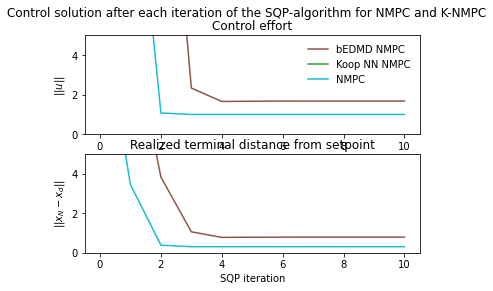

Solution statistics

                        Number of SQP    Mean comp. time per    Std comp. time per    Total comp.
                           iterations       iteration (secs)      iteration (secs)    time (secs)
--------------------  ---------------  ---------------------  --------------------  -------------
Nonlinear MPC                      11               0.333727             0.0120859         3.671
Koopman bilinear MPC               12               3.28819              0.580916         39.4583


In [ ]:
plt.figure(figsize=(6,4))
plt.suptitle('Control solution after each iteration of the SQP-algorithm for NMPC and K-NMPC')
plt.subplot(2,1,1)
plt.plot(np.arange(n_iter), iter_cost_bedmd[:n_iter]/iter_cost_nmpc[-1], color=colors[2], label='bEDMD NMPC')
plt.plot(np.arange(n_iter), iter_cost_koop_dnn[:n_iter]/iter_cost_nmpc[-1], color=colors[3], label='Koop NN NMPC')
plt.plot(np.arange(n_iter), iter_cost_nmpc[:n_iter]/iter_cost_nmpc[-1], color=colors[4], label='NMPC')
plt.ylim(0,5)
plt.title('Control effort')
plt.ylabel('$||u||$')
plt.legend(loc='upper right', frameon=False)
plt.xlabel('SQP iteration')

plt.subplot(2,1,2)
plt.plot(np.arange(n_iter), iter_norm_dist_bedmd[:n_iter], color=colors[2])
plt.plot(np.arange(n_iter), iter_norm_dist_koop_dnn[:n_iter], color=colors[3])
plt.plot(np.arange(n_iter), iter_norm_dist_nmpc[:n_iter], color=colors[4])
plt.ylim(0,5)
plt.title('Realized terminal distance from setpoint')
plt.ylabel('$||x_N - x_d||$')
plt.xlabel('SQP iteration')

if save_figures:
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(dropbox_folder + 'planar_quad_sqp_iterations.pdf', format='pdf', dpi=2400)

plt.show()

print('Solution statistics\n')
print(tabulate([['Nonlinear MPC', len(controller_nmpc.x_iter), np.mean(controller_nmpc.comp_time), np.std(controller_nmpc.comp_time), sum(controller_nmpc.comp_time)],
                ['Koopman bilinear MPC', len(controller_bedmd.x_iter), np.mean(controller_bedmd.comp_time), np.std(controller_bedmd.comp_time), sum(controller_bedmd.comp_time)]], 
               headers=['Number of SQP\niterations','Mean comp. time per\niteration (secs)', 'Std comp. time per\niteration (secs)', 'Total comp.\ntime (secs)']))

# Evaluate performance of controllers for closed-loop control

#### Design finite horizon controllers

In [ ]:
from koopman_core.controllers import PerturbedController

Q_mpc_cl = sc.sparse.diags([1e3, 1e3, 1e3, 1e2, 1e2, 1e2])
QN_mpc_cl = Q_mpc_cl
R_mpc_cl = sc.sparse.eye(m)
traj_duration = 0.5
N_cl = int(traj_duration/dt)
t_eval_cl=np.arange(250)*dt

solver_settings_cl = solver_settings

In [ ]:
controller_dmd_cl = MPCController(sys_dmd, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl, add_slack=True)
controller_dmd_cl = PerturbedController(sys_dmd,controller_dmd_cl,0.,const_offset=hover_thrust, umin=umin, umax=umax)

controller_edmd_cl = MPCController(sys_edmd, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl, add_slack=True)
controller_edmd_cl = PerturbedController(sys_edmd,controller_edmd_cl,0.,const_offset=hover_thrust, umin=umin, umax=umax)

controller_bedmd_cl = BilinearMPCControllerNb(sys_bedmd, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl, solver_settings_cl, add_slack=True)
controller_bedmd_cl.construct_controller(controller_bedmd.cur_z[:N_cl+1,:], controller_bedmd.cur_u[:N_cl,:])
controller_bedmd_cl.solve_to_convergence(z0_bedmd_cl, 0., controller_bedmd.cur_z[:N_cl+1,:], controller_bedmd.cur_u[:N_cl,:], max_iter=max_iter)
_ = controller_bedmd_cl.eval(x0_cl, 0.)
controller_bedmd_cl = PerturbedController(sys_bedmd,controller_bedmd_cl,0., umin=umin, umax=umax)

controller_koop_dnn_cl = BilinearMPCControllerNb(sys_koop_dnn, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl, solver_settings_cl, add_slack=True)
controller_koop_dnn_cl.construct_controller(controller_koop_dnn.cur_z[:N_cl+1,:], controller_koop_dnn.cur_u[:N_cl,:])
controller_koop_dnn_cl.solve_to_convergence(z0_koop_dnn_cl, 0., controller_koop_dnn.cur_z[:N_cl+1,:], controller_koop_dnn.cur_u[:N_cl,:], max_iter=max_iter)
_ = controller_koop_dnn_cl.eval(x0_cl, 0.)
controller_koop_dnn_cl = PerturbedController(sys_koop_dnn,controller_koop_dnn_cl,0.)

controller_nmpc_cl = NonlinearMPCControllerNb(quadrotor_d, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl, solver_settings_cl, add_slack=True)
controller_nmpc_cl.construct_controller(controller_nmpc.cur_z[:N_cl+1,:], controller_nmpc.cur_u[:N_cl,:])
controller_nmpc_cl.solve_to_convergence(x0_cl, 0., controller_nmpc.cur_z[:N_cl+1,:], controller_nmpc.cur_u[:N_cl,:], max_iter=max_iter)
_ = controller_nmpc_cl.eval(x0_cl, 0.)

In [ ]:
controller_bedmd_cl.nom_controller.comp_time, controller_bedmd_cl.nom_controller.prep_time, controller_bedmd_cl.nom_controller.qp_time,  = [], [], []
controller_koop_dnn_cl.nom_controller.comp_time, controller_koop_dnn_cl.nom_controller.prep_time, controller_koop_dnn_cl.nom_controller.qp_time,  = [], [], []
controller_nmpc_cl.comp_time, controller_nmpc_cl.prep_time, controller_nmpc_cl.qp_time,  = [], [], []

In [ ]:
solver_settings_cl['polish'] = False
solver_settings_cl['check_termination'] = 10
solver_settings_cl['max_iter'] = 10
solver_settings_cl['eps_abs'] = 1e-2
solver_settings_cl['eps_rel'] = 1e-2
solver_settings['eps_prim_inf'] = 1e-3
solver_settings['eps_dual_inf'] = 1e-3

controller_nmpc_cl.update_solver_settings(solver_settings_cl)
controller_koop_dnn_cl.nom_controller.update_solver_settings(solver_settings_cl)
controller_bedmd_cl.nom_controller.update_solver_settings(solver_settings_cl)

#### Simulate designed trajectories closed-loop

In [ ]:
xs_dmd_cl, us_dmd_cl = quadrotor.simulate(x0_cl, controller_dmd_cl, t_eval_cl)
xs_dmd_cl, us_dmd_cl = xs_dmd_cl.T, us_dmd_cl.T

xs_edmd_cl, us_edmd_cl = quadrotor.simulate(x0_cl, controller_edmd_cl, t_eval_cl)
xs_edmd_cl, us_edmd_cl = xs_edmd_cl.T, us_edmd_cl.T

controller_bedmd_cl.comp_time = []
xs_bedmd_cl, us_bedmd_cl = quadrotor.simulate(x0_cl, controller_bedmd_cl, t_eval_cl)
xs_bedmd_cl, us_bedmd_cl = xs_bedmd_cl.T, us_bedmd_cl.T

controller_koop_dnn_cl.comp_time = []
xs_koop_dnn_cl, us_koop_dnn_cl = quadrotor.simulate(x0_cl, controller_koop_dnn_cl, t_eval_cl)
xs_koop_dnn_cl, us_koop_dnn_cl = xs_koop_dnn_cl.T, us_koop_dnn_cl.T

controller_nmpc_cl.comp_time = []
xs_nmpc_cl, us_nmpc_cl = quadrotor.simulate(x0_cl, controller_nmpc_cl, t_eval_cl)
xs_nmpc_cl, us_nmpc_cl = xs_nmpc_cl.T, us_nmpc_cl.T

#### Plot/analyze the results

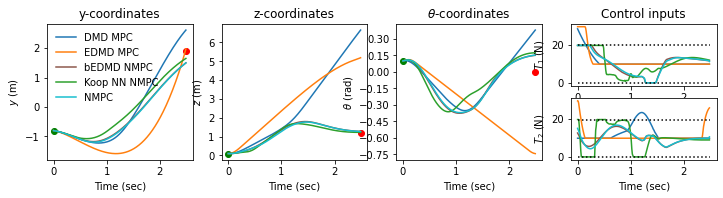

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


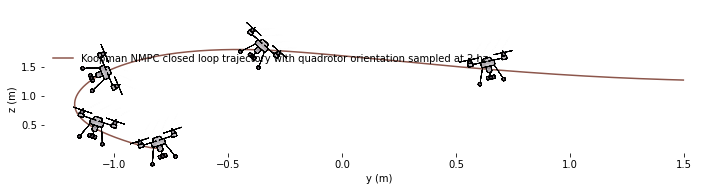

Solution statistics:

                                    Normalized cost,    Mean comp. time (secs)    std comp. time (secs)
                                 realized trajectory
-----------------------------  ---------------------  ------------------------  -----------------------
DMD MPC                                       1.9733                0.00139478              0.000337192
EDMD MPC                                      2.2535                0.00590327              0.000988965
bEDMD NMPC                                    0.9917                0.00690279              0.0025357
Koop NN NMPC                                  0.8894                0.00232451              0.000176254
NMPC (benchmark, known model)                 1                     0.0041304               0.000465672


In [ ]:
plot_inds = [0, 1, 2, 0, 1]
subplot_inds = [1, 2, 3, 4, 8]

plt.figure(figsize=(12,2.5))
for ii in range(5):
    ind = plot_inds[ii]
    if ii < 3:
        ax = plt.subplot(1,4,subplot_inds[ii])
        plt.plot(t_eval_cl, xs_dmd_cl[ind,:], colors[0], label='DMD MPC')
        plt.plot(t_eval_cl, xs_edmd_cl[ind, :], colors[1], label='EDMD MPC')
        plt.plot(t_eval_cl, xs_bedmd_cl[ind, :], colors[2], label='bEDMD NMPC')
        plt.plot(t_eval_cl, xs_koop_dnn_cl[ind, :], colors[3], label='Koop NN NMPC')
        plt.plot(t_eval_cl, xs_nmpc_cl[ind,:], colors[4], label='NMPC')

        plt.scatter(t_eval_cl[0], x0_cl[ind], color='g')
        plt.scatter(t_eval_cl[-1], set_pt_cl[ind], color='r')
        plt.ylabel(labels[ind])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.title(titles[subplot_inds[ii]-1])
        plt.xlabel('Time (sec)')
        if subplot_inds[ii]==1:
            plt.legend(loc='upper left', frameon=False)
    else:
        bx = plt.subplot(2,4,subplot_inds[ii])
        plt.plot(t_eval_cl[:-1],us_dmd_cl[ind,:], color=colors[0], label='DMD MPC')
        plt.plot(t_eval_cl[:-1], us_edmd_cl[ind, :], color=colors[1], label='EDMD MPC')
        plt.plot(t_eval_cl[:-1], us_bedmd_cl[ind, :], color=colors[2], label='bEDMD NMPC')
        plt.plot(t_eval_cl[:-1], us_koop_dnn_cl[ind, :], color=colors[3], label='Koop NN NMPC')
        plt.plot(t_eval_cl[:-1],us_nmpc_cl[ind,:], color=colors[4], label='NMPC')
        plt.plot([0, t_eval_cl[-1]], [umax[ind], umax[ind]], ':k')
        plt.plot([0, t_eval_cl[-1]], [umin[ind], umin[ind]], ':k')
        plt.ylabel(labels[ii+3])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        if subplot_inds[ii] == 4:
            plt.title('Control inputs')
        else:
            plt.xlabel('Time (sec)')
if save_figures:
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(dropbox_folder + 'planar_quad_closed_loop.pdf', format='pdf', dpi=2400)
plt.show()
    
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from scipy import ndimage

draw_inds = np.arange(0,t_eval_cl.size)[::50]

plt.figure(figsize=(12,2))
ax = plt.subplot(1,1,1, frameon=False)
plt.plot(xs_bedmd_cl[0,:], xs_bedmd_cl[1,:], color=colors[2], label='Koopman NMPC closed loop trajectory with quadrotor orientation sampled at 2 hz')
plt.xlabel('y (m)')
plt.ylabel('z (m)')
plt.legend(loc='upper left',frameon=False)
for ii in draw_inds:
    im_quad = plt.imread('working_files/figures/quad_figure_rb.png')
    im_quad = ndimage.rotate(im_quad, xs_bedmd_cl[2,ii]*180)
    imagebox_quad = OffsetImage(im_quad, zoom=.11)
    ab = AnnotationBbox(imagebox_quad, [xs_bedmd_cl[0,ii], xs_bedmd_cl[1,ii]], frameon=False)
    ax.add_artist(ab)

if save_figures:
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(dropbox_folder + 'planar_quad_closed_loop_2.pdf', format='pdf', dpi=2400)
plt.show()

cost_cl_dmd = np.sum(np.diag((xs_dmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)).T@Q_mpc_cl@(xs_dmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)))) + (xs_dmd_cl[:,-1]-set_pt_cl).T@QN_mpc_cl@(xs_dmd_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_dmd_cl.T@R_mpc_cl@us_dmd_cl))
cost_cl_edmd = np.sum(np.diag((xs_edmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)).T@Q_mpc_cl@(xs_edmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)))) + (xs_edmd_cl[:,-1]-set_pt_cl).T@QN_mpc_cl@(xs_edmd_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_edmd_cl.T@R_mpc_cl@us_edmd_cl))
cost_cl_bedmd = np.sum(np.diag((xs_bedmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)).T@Q_mpc_cl@(xs_bedmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)))) + (xs_bedmd_cl[:,-1]-set_pt_cl).T@QN_mpc_cl@(xs_bedmd_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_bedmd_cl.T@R_mpc_cl@us_bedmd_cl))
cost_cl_koop_dnn = np.sum(np.diag((xs_koop_dnn_cl[:,:-1]-set_pt_cl.reshape(-1,1)).T@Q_mpc_cl@(xs_koop_dnn_cl[:,:-1]-set_pt_cl.reshape(-1,1)))) + (xs_koop_dnn_cl[:,-1]-set_pt_cl).T@QN_mpc_cl@(xs_koop_dnn_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_koop_dnn_cl.T@R_mpc_cl@us_koop_dnn_cl))
cost_cl_nmpc = np.sum(np.diag((xs_nmpc_cl[:,:-1]-set_pt_cl.reshape(-1,1)).T@Q_mpc_cl@(xs_nmpc_cl[:,:-1]-set_pt_cl.reshape(-1,1)))) + (xs_nmpc_cl[:,-1]-set_pt_cl).T@QN_mpc_cl@(xs_nmpc_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_nmpc_cl.T@R_mpc_cl@us_nmpc_cl))

print('Solution statistics:\n')
print(tabulate([['DMD MPC', "{:.4f}".format(cost_cl_dmd/cost_cl_nmpc), np.mean(controller_dmd_cl.nom_controller.comp_time), np.std(controller_dmd_cl.nom_controller.comp_time)], 
                ['EDMD MPC', "{:.4f}".format(cost_cl_edmd/cost_cl_nmpc),np.mean(controller_edmd_cl.nom_controller.comp_time), np.std(controller_edmd_cl.nom_controller.comp_time)], 
                ['bEDMD NMPC', "{:.4f}".format(cost_cl_bedmd/cost_cl_nmpc), np.mean(controller_bedmd_cl.nom_controller.comp_time), np.std(controller_bedmd_cl.nom_controller.comp_time)],
                ['Koop NN NMPC', "{:.4f}".format(cost_cl_koop_dnn/cost_cl_nmpc), np.mean(controller_koop_dnn_cl.nom_controller.comp_time), np.std(controller_koop_dnn_cl.nom_controller.comp_time)],
                ['NMPC (benchmark, known model)',1, np.mean(controller_nmpc_cl.comp_time), np.std(controller_nmpc_cl.comp_time)]], 
               headers=['Normalized cost,\nrealized trajectory', 'Mean comp. time (secs)', 'std comp. time (secs)']))

In [ ]:
print('\nSolution time profiling:\n')
print(tabulate([['NMPC', np.mean(controller_nmpc_cl.comp_time), np.mean(controller_nmpc_cl.prep_time), np.mean(controller_nmpc_cl.qp_time)],
                ['Koop NN NMPC', np.mean(controller_koop_dnn_cl.nom_controller.comp_time), np.mean(controller_koop_dnn_cl.nom_controller.prep_time), np.mean(controller_koop_dnn_cl.nom_controller.qp_time)],
                ['bEDMD NMPC', np.mean(controller_bedmd_cl.nom_controller.comp_time), np.mean(controller_bedmd_cl.nom_controller.prep_time), np.mean(controller_bedmd_cl.nom_controller.qp_time)]],
               headers=['Total comp time', 'setup time', 'qp solve time' ]))


Solution time profiling:

                Total comp time    setup time    qp solve time
------------  -----------------  ------------  ---------------
NMPC                 0.0041304    0.00358627        0.00054413
Koop NN NMPC         0.00232451   0.000923325       0.00140119
bEDMD NMPC           0.00690279   0.00224812        0.00465467
